## Contents  
<ol>
    <b><li>Importing libraries</li></b>
    <li><b>Importing and organizing the data</b>
        <ol>
            <li>Convert the columns types for the features to float</li>
            <li>Convert the class label types to int</li>
        </ol>
    </li>
    <li><b>Data Analysis and Preprocessing</b>
        <ol>
            <li>Missing Data Analysis
                <ol>
                    <li>Generate Sparsity Matrix for the missing data</li>
                    <li>Generate Heat Map for the missing data</li>
                </ol>
            </li>
            <li>Data Imputation
                <ol>
                    <li>Mean Imputation</li>
                    <li>K-NN</li>
                </ol>
            </li>
            <li>Dealing with imbalanced data
                <ol>
                    <li>Oversampling with SMOTE</li>
                </ol>
            </li>
        </ol>
    </li>
    <li><b>Data Modeling</b>
        <ol>
            <li>K-Fold Cross validation</li>
            <li>Models
                <ol>
                    <li>Adaboost classifier</li>
                    <li>Nueral Network classifier</li>
                    <li>K-NearestNeighbor</li>
                    <li>Random Forest classifier</li>
                    <li>Extreme Gradient Boosting classifier</li>
                    <li>Bagging classifier</li>
                </ol>
            </li>
        </ol>
    </li>
    <li><b>Model Analysis</b>
        <ol>
            <li>Model ranking</li>
            <li>Effect of varying number of estimators on the accuracy scores on different datasets</li>
            <li>Plotting effect of number of estimators on Accuracy</li>
        </ol>
    </li>
    <li><b>References</b></li>
</ol>

## 1. Importing libraries

In [49]:
# To supress warnings
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Basic Libraries for Data organization, Statistical operations and Plotting
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# For loading .arff files
from scipy.io import arff
# To analyze the type of missing data
import missingno as msno
# Library to perform Expectation-Maximization (EM) imputation
import impyute as impy
# To perform mean imputation
from sklearn.impute import SimpleImputer
#To perform kFold Cross Validation
from sklearn.model_selection import KFold
# Formatted counter of class labels
from collections import Counter
# Ordered Dictionary
from collections import OrderedDict
# Library imbalanced-learn to deal with the data imbalance. To use SMOTE oversampling
from imblearn.over_sampling import SMOTE 

# Impoting classification models
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
import random

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve

In [50]:
# Library for performing k-NN imputations 
import fancyimpute

## 2. Importing and organizing the data

<b>Dataset Link:</b>[Polish bankruptcy dataset](https://archive.ics.uci.edu/ml/datasets/Polish+companies+bankruptcy+data)

The column labels for the features are like `X1`, `X2`, ... , `X64`. The class label is `Y`.   
Print the first 5 rows of a dataframe, to see how the data looks like.

In [51]:
############################################################
# Loads the raw .arff files into a list
def load_arff_raw_data():
    return arff.loadarff('5year.arff') 

############################################################
# Loads the raw .arff files into pandas dataframes
def load_dataframes():
    return pd.DataFrame(load_arff_raw_data()[0])

############################################################
# Set the column headers from X1 ... X64 and the class label as Y
def set_new_headers(dataframes):
    cols = ['X' + str(i+1) for i in range(len(dataframes.columns)-1)]
    cols.append('Y')
    dataframes.columns = cols

############################################################
# dataframes is the list of pandas dataframes 
dataframes = load_dataframes()

# Set the new headers for the dataframes. The new headers will have the renamed set of feature (X1 to X64)
set_new_headers(dataframes)    

# print the first 5 rows of  dataset
dataframes.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X56,X57,X58,X59,X60,X61,X62,X63,X64,Y
0,0.088238,0.55472,0.01134,1.0205,-66.5200,0.342040,0.109490,0.57752,1.0881,0.32036,...,0.080955,0.275430,0.91905,0.002024,7.2711,4.7343,142.760,2.5568,3.2597,b'0'
1,-0.006202,0.48465,0.23298,1.5998,6.1825,0.000000,-0.006202,1.06340,1.2757,0.51535,...,-0.028591,-0.012035,1.00470,0.152220,6.0911,3.2749,111.140,3.2841,3.3700,b'0'
2,0.130240,0.22142,0.57751,3.6082,120.0400,0.187640,0.162120,3.05900,1.1415,0.67731,...,0.123960,0.192290,0.87604,0.000000,8.7934,2.9870,71.531,5.1027,5.6188,b'0'
3,-0.089951,0.88700,0.26927,1.5222,-55.9920,-0.073957,-0.089951,0.12740,1.2754,0.11300,...,0.418840,-0.796020,0.59074,2.878700,7.6524,3.3302,147.560,2.4735,5.9299,b'0'
4,0.048179,0.55041,0.10765,1.2437,-22.9590,0.000000,0.059280,0.81682,1.5150,0.44959,...,0.240400,0.107160,0.77048,0.139380,10.1180,4.0950,106.430,3.4294,3.3622,b'0'


#### 2.A Convert the columns types for the features to float
The numeric data shown in the dataframe above is infact a python object. Let us convert all the numberic features for the dataframe into float to maintain consistency.

In [52]:
# Convert the dtypes of all the columns (other than the class label columns) to float.
def convert_columns_type_float(dfs):
    
    index = 1
    while(index<=63):
        colname = dfs.columns[index]
        col = getattr(dfs, colname)
        dfs[colname] = col.astype(float)
        index+=1
            
convert_columns_type_float(dataframes)
dataframes.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X56,X57,X58,X59,X60,X61,X62,X63,X64,Y
0,0.088238,0.55472,0.01134,1.0205,-66.5200,0.342040,0.109490,0.57752,1.0881,0.32036,...,0.080955,0.275430,0.91905,0.002024,7.2711,4.7343,142.760,2.5568,3.2597,b'0'
1,-0.006202,0.48465,0.23298,1.5998,6.1825,0.000000,-0.006202,1.06340,1.2757,0.51535,...,-0.028591,-0.012035,1.00470,0.152220,6.0911,3.2749,111.140,3.2841,3.3700,b'0'
2,0.130240,0.22142,0.57751,3.6082,120.0400,0.187640,0.162120,3.05900,1.1415,0.67731,...,0.123960,0.192290,0.87604,0.000000,8.7934,2.9870,71.531,5.1027,5.6188,b'0'
3,-0.089951,0.88700,0.26927,1.5222,-55.9920,-0.073957,-0.089951,0.12740,1.2754,0.11300,...,0.418840,-0.796020,0.59074,2.878700,7.6524,3.3302,147.560,2.4735,5.9299,b'0'
4,0.048179,0.55041,0.10765,1.2437,-22.9590,0.000000,0.059280,0.81682,1.5150,0.44959,...,0.240400,0.107160,0.77048,0.139380,10.1180,4.0950,106.430,3.4294,3.3622,b'0'


#### 2.B Convert the class label types to int
If we look the class label `Y`, we notice that the values are shown either as `b'0'` or `b'1'`   
They actually correspond to bankruptcy being false and true respectively.   
It is convenient to convert them to binary integers 0 and 1 respectively.

In [53]:
# The class labels for all the dataframes are originally in object type.
# Convert them to int types
def convert_class_label_type_int(dfs):
    col = getattr(dfs, 'Y')
    dfs['Y'] = col.astype(int)
        
convert_class_label_type_int(dataframes)
dataframes.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X56,X57,X58,X59,X60,X61,X62,X63,X64,Y
0,0.088238,0.55472,0.01134,1.0205,-66.5200,0.342040,0.109490,0.57752,1.0881,0.32036,...,0.080955,0.275430,0.91905,0.002024,7.2711,4.7343,142.760,2.5568,3.2597,0
1,-0.006202,0.48465,0.23298,1.5998,6.1825,0.000000,-0.006202,1.06340,1.2757,0.51535,...,-0.028591,-0.012035,1.00470,0.152220,6.0911,3.2749,111.140,3.2841,3.3700,0
2,0.130240,0.22142,0.57751,3.6082,120.0400,0.187640,0.162120,3.05900,1.1415,0.67731,...,0.123960,0.192290,0.87604,0.000000,8.7934,2.9870,71.531,5.1027,5.6188,0
3,-0.089951,0.88700,0.26927,1.5222,-55.9920,-0.073957,-0.089951,0.12740,1.2754,0.11300,...,0.418840,-0.796020,0.59074,2.878700,7.6524,3.3302,147.560,2.4735,5.9299,0
4,0.048179,0.55041,0.10765,1.2437,-22.9590,0.000000,0.059280,0.81682,1.5150,0.44959,...,0.240400,0.107160,0.77048,0.139380,10.1180,4.0950,106.430,3.4294,3.3622,0


## 3. Data Analysis and Preprocessing

### 3.A Missing Data Analysis
Surely, there is missing data. Let us now see how much of it is missing

In [54]:
############################################################
# Get Clean dataframes by dropping all the rows which have missing values
def drop_nan_rows(dataframes, verbose=False):
    clean_dataframes = dataframes.dropna(axis=0, how='any') 
    if verbose:
        print('5year:','Original Length=', len(dataframes), '\tCleaned Length=', len(clean_dataframes), '\tMissing Data=', len(dataframes)-len(clean_dataframes))
    return clean_dataframes

# Doing a quick analysis of how many missing values are there in each of the 5 dataframes
nan_dropped_dataframes = drop_nan_rows(dataframes, verbose=True)

5year: Original Length= 5910 	Cleaned Length= 3031 	Missing Data= 2879


The above step shows us that there are a lot of rows in the dataframe which have missing data in at least one of the features. The missing-data-rows correspond to more than 50% of the entire data.   

#### 3.A.a Generate Sparsity Matrix for the missing data
Now that we have established that there is a lot of missing data, let us find out if the missing data has some correlation.   
The `matrix` function from the `missingno` library helps us generate sparsity matrix, which shows us the gaps in the data.

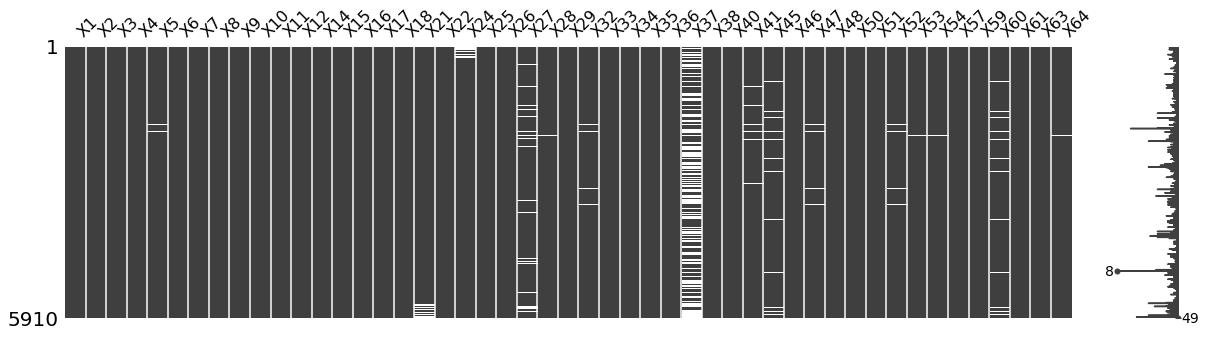

In [55]:
# generate the sparsity matrix (figure) for all the dataframes
def generate_sparsity_matrix(dfs):
    missing_df = dfs.columns[dfs.isnull().any()].tolist()
    msno.matrix(dfs[missing_df], figsize=(20,5))

generate_sparsity_matrix(dataframes)

From the above plots of sparsity for the dataframe, we could notice a lot of sparsity for the feature `X37` has the highest sparsity among all the features.   

#### 3.A.b Generate Heat Map for the missing data   
Now, let us find out if there is some correlation among the missing features.    

Using the `heatmap` function from `missingno` library, let us plot the heatmaps for the dataframe.

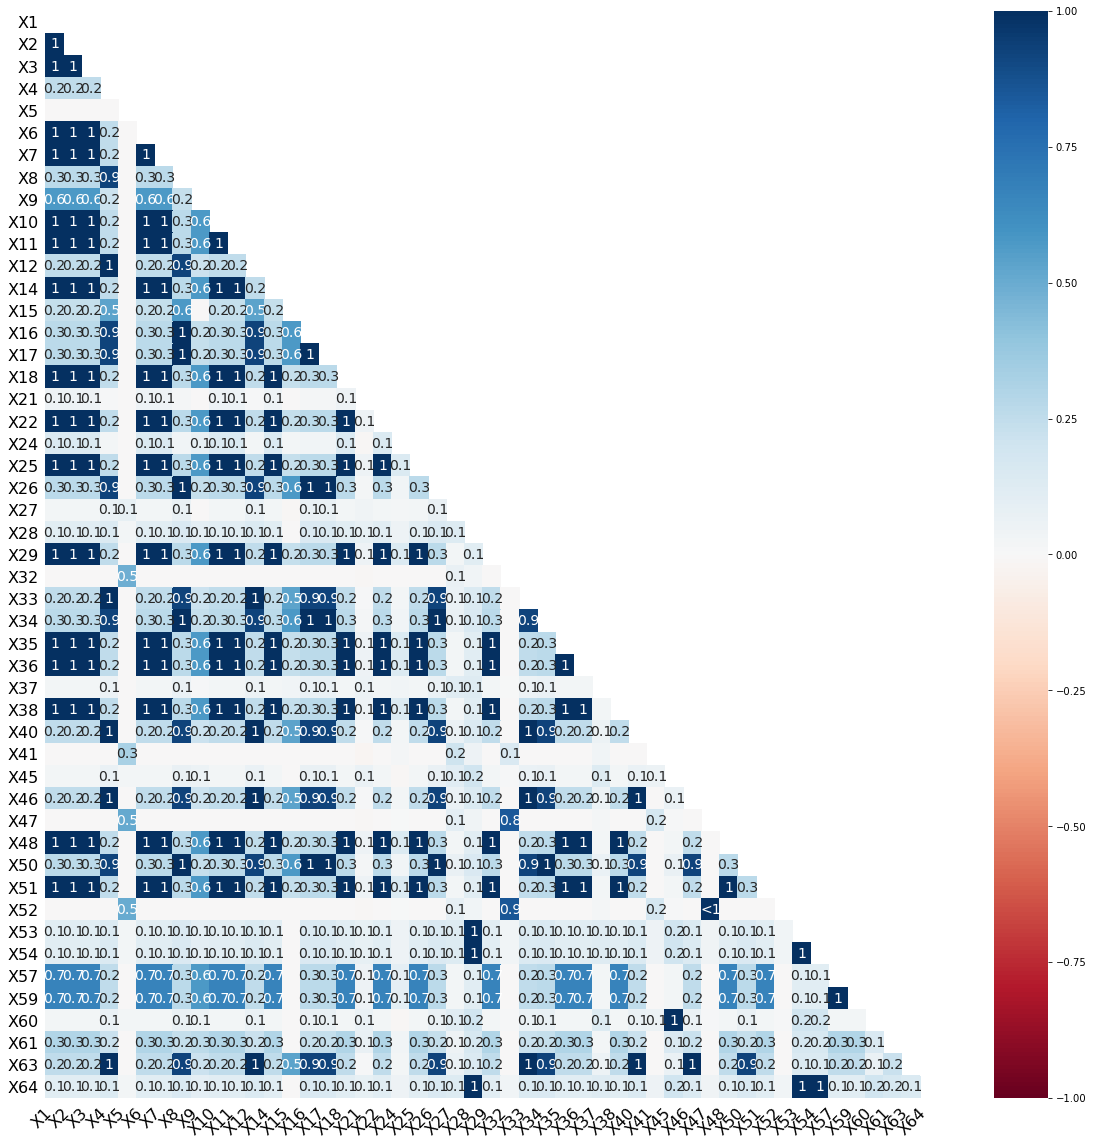

In [56]:
# generate the heatmap for all the dataframes
def generate_heatmap(dfs):
    missing_df = dfs.columns[dfs.isnull().any()].tolist()
    msno.heatmap(dfs[missing_df], figsize=(20,20))
        
generate_heatmap(dataframes)        

The heat maps above, for the dataframe, describe the degree of nullity relationship between different features.    The range of this nullity correlation is from -1 to 1 (-1 ≤ R ≤ 1).    
Features with no missing value are excluded in the heatmap. If the nullity correlation is very close to zero (-0.05 < R < 0.05), no value will be displayed.    

A perfect positive nullity correlation (R=1) indicates when the first feature and the second feature both have corresponding missing values.       

A perfect negative nullity correlation (R=-1) means that one of the features is missing and the second is not missing.   

The takeaway is that, in each dataframe, there are some features that are heavily correlated (R = 1 or -1) and also there are features that are not essentially correlated (R values close to 0)

### 3.B Data Imputation

It is now established that we need to impute (fill in the gaps) the missing data, as dropping the missing rows or eliminating the missing features is not an option.   

We would like to explore some of the widely used missing data imputation techniques.   
<b>
1. Mean Imputation (baseline method)
2. k Nearest Neighbors (k-NN) Imputation
</b>

#### 3.B.a Mean Imputation

In [57]:
def perform_mean_imputation(dfs):
    # Construct an imputer with strategy as 'mean', to mean-impute along the columns
    imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
    mean_imputed_dfs = pd.DataFrame(imputer.fit_transform(dfs))
    
    mean_imputed_dfs.columns = dfs.columns   
    return mean_imputed_dfs

mean_imputed_dataframes = perform_mean_imputation(dataframes)

#### 3.B.b k-Nearest Neighbors (k-NN) Imputation

In [58]:
def perform_knn_imputation(dfs):
    knn_imputed_datasets = fancyimpute.KNN(k=100,verbose=True).fit_transform(dfs)
    return pd.DataFrame(data=knn_imputed_datasets) 
    
knn_imputed_dataframes = perform_knn_imputation(dataframes)
set_new_headers(knn_imputed_dataframes)

Imputing row 1/5910 with 0 missing, elapsed time: 20.844
Imputing row 101/5910 with 1 missing, elapsed time: 20.857
Imputing row 201/5910 with 1 missing, elapsed time: 20.866
Imputing row 301/5910 with 0 missing, elapsed time: 20.872
Imputing row 401/5910 with 1 missing, elapsed time: 20.876
Imputing row 501/5910 with 0 missing, elapsed time: 20.882
Imputing row 601/5910 with 1 missing, elapsed time: 20.886
Imputing row 701/5910 with 1 missing, elapsed time: 20.890
Imputing row 801/5910 with 1 missing, elapsed time: 20.898
Imputing row 901/5910 with 0 missing, elapsed time: 20.905
Imputing row 1001/5910 with 3 missing, elapsed time: 20.910
Imputing row 1101/5910 with 0 missing, elapsed time: 20.917
Imputing row 1201/5910 with 1 missing, elapsed time: 20.921
Imputing row 1301/5910 with 1 missing, elapsed time: 20.926
Imputing row 1401/5910 with 1 missing, elapsed time: 20.933
Imputing row 1501/5910 with 0 missing, elapsed time: 20.937
Imputing row 1601/5910 with 0 missing, elapsed time:

In the above 2 steps, we have successfully created 2 differently imputed dataframes using: Mean, k-NN techniques respectively.   

Here below, we create a dictionary of all the imputed dataframes to re-use them in the future. 

In [59]:
imputed_dataframes_dictionary = OrderedDict()
imputed_dataframes_dictionary['Mean'] = mean_imputed_dataframes
#imputed_dataframes_dictionary['k-NN'] = knn_imputed_dataframes

### ---------------------------------------------------------------------------------------------------------------------------------------------------------

### 3.C Dealing with imbalanced data   

In the steps seen above, we have successfully dealt with the missing data. But we have not dealt with the class imbalance (if any) in the data. Simply put, Data Imbalance is a condition where the samples belonging to one or more 'majority' class labels of a labelled dataset heavily outnumber the sample belonging to the other 'minority' classes.   

Data imbalance critically affects the modeling as the models won't have sufficient data belonging to minority classes to train on and this leads to biased models, ultimately leading to poor performance on test data.   

Firstly, let us see if our data is imbalanced, and to what extent.

In [60]:
def check_data_imbalance(dfs):
   
    print('Dataset: ')
    print(dfs.groupby('Y').size())
    minority_percent = (dfs['Y'].tolist().count(1) / len(dfs['Y'].tolist()))*100
    print('Minority (label 1) percentage: '+  str(minority_percent) + '%')
    print('-'*64)
        
check_data_imbalance(dataframes)
type(dataframes)

Dataset: 
Y
0    5500
1     410
dtype: int64
Minority (label 1) percentage: 6.937394247038917%
----------------------------------------------------------------


pandas.core.frame.DataFrame

We have seen in the step above that there is a lot of data imbalance for our datasets, as indicated by the percentage of minority class (label `1`) samples among their datasets. With this huge magnitude of data imbalance, the models will not train wel if we leave them as is. 

#### 3.C.a Oversampling with SMOTE (Synthetic Minority Over Sampling Technique)

In [61]:
# Split the features and labels into separate dataframes for all the original dataframes
def split_dataframes_features_labels(dfs):
    feature_dfs = dfs.iloc[:,0:64]
    label_dfs = dfs.iloc[:,64] 
    return feature_dfs, label_dfs

# Performs the SMOTE oversampling fro given dataframes.
def oversample_data_SMOTE(dfs, verbose=False):
    smote = SMOTE(sampling_strategy=1 , random_state=42, k_neighbors=10)
    #Split the features and labels for each dataframe
    feature_dfs, label_dfs = split_dataframes_features_labels(dfs)
    resampled_feature_arrays = []
    resampled_label_arrays = []
    
    if verbose: print('Dataset: ' )
    if verbose: print('Original dataset shape {}'.format(Counter(label_dfs)))
    df_features_res, df_label_res = smote.fit_resample(feature_dfs, label_dfs)
    if verbose: print('Resampled dataset shape {}\n'.format(Counter(df_label_res)))
    # Append the resampled feature and label arrays of ith dataframe to their respective list of arrays    
    resampled_feature_arrays.append(df_features_res)
    resampled_label_arrays.append(df_label_res)        
    return resampled_feature_arrays, resampled_label_arrays

# Utility Function to convert the arrays of features and labels to pandas dataframes, and then join them.
# Also re-assign the columns headers.
def restructure_arrays_to_dataframes(feature_arrays, label_arrays):
    resampled_dfs =[]
    for i in range(len(feature_arrays)):
        feature_df = pd.DataFrame(data=feature_arrays[i])
        label_df = pd.DataFrame(data=label_arrays[i])
        # Must set the column header for label_df, otherwise it wont join with feature_df, as columns overlap (with col names '0')
        label_df.columns=['Y'] 
        resampled_dfs.append(feature_df.join(label_df))
    # re-assign the column headers for features and labels    
    set_new_headers(resampled_dfs[0])    
    return resampled_dfs

# Perform SMOTE oversampling on all the imputed dataframes, and return them in a dictionary.
def perform_oversampling_on_imputed_dataframes(df_dict):
    imputed_oversampled_dataframes_dictionary = OrderedDict()
    for key,dfs in df_dict.items():
        print('SMOTE Oversampling for ' + key + ' imputed dataframes\n')
        smote_feature_arrays, smote_label_arrays = oversample_data_SMOTE(dfs, verbose=True)
        oversampled_dataframes = restructure_arrays_to_dataframes(smote_feature_arrays, smote_label_arrays)
        imputed_oversampled_dataframes_dictionary[key] = oversampled_dataframes
        print('-'*100)
    return imputed_oversampled_dataframes_dictionary

imputed_oversampled_dataframes_dictionary = perform_oversampling_on_imputed_dataframes(imputed_dataframes_dictionary)
imputed_oversampled_dataframes_dictionary

SMOTE Oversampling for Mean imputed dataframes

Dataset: 
Original dataset shape Counter({0.0: 5500, 1.0: 410})
Resampled dataset shape Counter({0.0: 5500, 1.0: 5500})

----------------------------------------------------------------------------------------------------


OrderedDict([('Mean',
              [             X1        X2        X3        X4           X5        X6  \
               0      0.088238  0.554720  0.011340  1.020500   -66.520000  0.342040   
               1     -0.006202  0.484650  0.232980  1.599800     6.182500  0.000000   
               2      0.130240  0.221420  0.577510  3.608200   120.040000  0.187640   
               3     -0.089951  0.887000  0.269270  1.522200   -55.992000 -0.073957   
               4      0.048179  0.550410  0.107650  1.243700   -22.959000  0.000000   
               ...         ...       ...       ...       ...          ...       ...   
               10995 -0.271406  1.040911 -0.725325  0.362591  -147.665320 -0.447710   
               10996 -0.188747  0.966279 -0.182217  0.812041   -97.269718 -0.018538   
               10997 -0.315550  0.105670  0.693460  8.825896    76.862356  0.000000   
               10998 -0.004090  0.694088  0.300292  1.832664  1215.258764 -0.028593   
               10999 

## 4. Data Modeling: Building Classification Models

### 4.A K-Fold Cross Validation

In [62]:
def prepare_kfold_cv_data(k, X, y, verbose=False):
    X = X.values
    y = y.values
    kf = KFold(n_splits=k, shuffle=False, random_state=None)
    X_train = []
    y_train = []
    X_test = []
    y_test = []
    
    for train_index, test_index in kf.split(X):
        X_train.append(X[train_index])
        y_train.append(y[train_index])
        X_test.append(X[test_index])
        y_test.append(y[test_index])
    return X_train, y_train, X_test, y_test

### 4.B MODELS

### 4.B.a  Adaboost classifier

In [63]:
# Adaboost classifier
ada_classifier = AdaBoostClassifier(n_estimators=10, random_state=42)

### 4.B.b Nueral Network classifier

In [64]:
# NN classifier
nn_classifier=MLPClassifier(hidden_layer_sizes=(10,5,10),alpha=0.01,max_iter=300)

### 4.B.c KNN Classifier

In [65]:
#knn_classifier
knn_classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)

### 4.B.d Random Forest Classifier

In [66]:
# Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators = 5, criterion = 'entropy')

### 4.B.e Extreme Gradient Boosting Classifier

In [67]:
# eXtreme Gradient Boosting Classifier (XGBClassifier)
xgb_classifier = XGBClassifier()

### 4.B.f Bagging Classifier

In [68]:
# Bagging Classifier
bag_classifier = BaggingClassifier()

In [69]:
# creating a dictionary of models
models_dictionary = OrderedDict()

models_dictionary['Adaboost'] = ada_classifier
models_dictionary['NN'] = nn_classifier
models_dictionary['knn'] = knn_classifier
models_dictionary['Extreme Gradient Boosting'] = xgb_classifier
models_dictionary['Random Forest'] = rf_classifier
models_dictionary['Bagging'] = bag_classifier

In [70]:
# perform data modeling
model_results = OrderedDict()
def perform_data_modeling(_models_, _imputers_, verbose=False, k_folds=5):
    
    # 6 Models
    # 2 Imputers
    # 2 dataset
    flag=1
    
    # Iterate over the models
    for model_name, clf in _models_.items():
        if verbose: print("-"*120, "\n", "Model: " + '\033[1m' + model_name + '\033[0m' + " Classifier")
        imputer_results = OrderedDict()
        
        # Iterate over the different imputed_data mechanisms (Mean, k-NN, EM, MICE)
        for imputer_name, dataframes_list in _imputers_.items():
            if verbose: print('\tImputer Technique: ' + '\033[1m' + imputer_name + '\033[0m')
            
            # call the split_dataframes_features_labels function to get a list of features and labels for all the dataframes
            #feature_dfs, label_dfs = split_dataframes_features_labels(dataframes_list) 
            feature_dfs = [dataframes_list[0].iloc[:,0:64]]
            label_dfs = [dataframes_list[0].iloc[:,64]]
           
            
            year_results = OrderedDict()
            
            # Iterate over dataframe_list individually
            for df_index in range(len(dataframes_list)):
                if verbose: print('\t\tDataset: ' + '\033[1m' '5year.aff'+ '\033[0m')
                
                # Calling the 'prepare_kfold_cv_data' returns lists of features and labels 
                # for train and test sets respectively.
                # The number of items in the list is equal to k_folds
                X_train_list, y_train_list, X_test_list, y_test_list = prepare_kfold_cv_data(k_folds, feature_dfs[df_index], label_dfs[df_index], verbose)
                
                metrics_results = OrderedDict()
                accuracy_list = np.zeros([k_folds])
                precision_list = np.zeros([k_folds,2])
                recall_list = np.zeros([k_folds,2])
                TN_list = np.zeros([k_folds])
                FP_list = np.zeros([k_folds])
                FN_list = np.zeros([k_folds])
                TP_list = np.zeros([k_folds])                
                
                # Iterate over all the k-folds
                for k_index in range(k_folds):
                    X_train = X_train_list[k_index]
                    y_train = y_train_list[k_index]
                    X_test = X_test_list[k_index]
                    y_test = y_test_list[k_index]
                    
                    # Fit the model and 
                    clf = clf.fit(X_train, y_train)
                    y_test_predicted = clf.predict(X_test)
                    if(flag):
                        X_test[0].tofile("1.txt","w+")
                        print(X_test[0])
                        flag-=1
                    
                    #code for calculating accuracy 
                    _accuracy_ = accuracy_score(y_test, y_test_predicted, normalize=True)
                    accuracy_list[k_index] = _accuracy_
                    
                    #code for calculating recall 
                    _recalls_ = recall_score(y_test, y_test_predicted, average=None)
                    recall_list[k_index] = _recalls_
                    
                    #code for calculating precision 
                    _precisions_ = precision_score(y_test, y_test_predicted, average=None)
                    precision_list[k_index] = _precisions_
                    
                    #code for calculating confusion matrix 
                    _confusion_matrix_ = confusion_matrix(y_test, y_test_predicted)
                    TN_list[k_index] = _confusion_matrix_[0][0]
                    FP_list[k_index] = _confusion_matrix_[0][1]
                    FN_list[k_index] = _confusion_matrix_[1][0]
                    TP_list[k_index] = _confusion_matrix_[1][1]
                
                # creating a metrics dictionary
                metrics_results['Accuracy'] = np.mean(accuracy_list)
                metrics_results['Precisions'] = np.mean(precision_list, axis=0)
                metrics_results['Recalls'] = np.mean(recall_list, axis=0)
                metrics_results['TN'] = np.mean(TN_list)
                metrics_results['FP'] = np.mean(FP_list)
                metrics_results['FN'] = np.mean(FN_list)
                metrics_results['TP'] = np.mean(TP_list)
                
                if verbose:
                    print('\t\t\tAccuracy:', metrics_results['Accuracy'])
                    print('\t\t\tPrecision:', metrics_results['Precisions'])
                    print('\t\t\tRecall:', metrics_results['Recalls'])
                
                year_results[str(df_index+1)+'year'] = metrics_results   
                
            imputer_results[imputer_name] = year_results
            
        model_results[model_name] = imputer_results  
        
    return model_results                

In [71]:
results = perform_data_modeling(models_dictionary, imputed_oversampled_dataframes_dictionary, verbose=True, k_folds=5)

------------------------------------------------------------------------------------------------------------------------ 
 Model: Adaboost Classifier
	Imputer Technique: Mean
		Dataset: 5year.aff
[ 8.8238e-02  5.5472e-01  1.1340e-02  1.0205e+00 -6.6520e+01  3.4204e-01
  1.0949e-01  5.7752e-01  1.0881e+00  3.2036e-01  1.0949e-01  1.9760e-01
  9.6885e-02  1.0949e-01  1.4752e+03  2.4742e-01  1.8027e+00  1.0949e-01
  7.7287e-02  5.0199e+01  1.1574e+00  1.3523e-01  6.2287e-02  4.1949e-01
  3.2036e-01  2.0912e-01  1.0387e+00  2.6093e-02  6.1267e+00  3.7788e-01
  7.7287e-02  1.5533e+02  2.3498e+00  2.4377e-01  1.3523e-01  1.4493e+00
  5.7137e+02  3.2101e-01  9.5457e-02  1.2879e-01  1.1189e-01  9.5457e-02
  1.2730e+02  7.7096e+01  4.5289e-01  6.6883e-01  5.4621e+01  1.0746e-01
  7.5859e-02  1.0193e+00  5.5407e-01  4.2557e-01  7.3717e-01  7.3866e-01
  1.5182e+04  8.0955e-02  2.7543e-01  9.1905e-01  2.0240e-03  7.2711e+00
  4.7343e+00  1.4276e+02  2.5568e+00  3.2597e+00]
			Accuracy: 0.811181818

In [72]:
# Original Data
#print(model_results)

def GetModelPerformance(s):
    if(model_results.get(s)==None): 
        return -1
    
    d=model_results[s]['Mean']['1year']
    l=[]
    l.append(d['Accuracy'])
    l.append(list(d['Precisions']))
    l.append(list(d['Recalls']))
    return l
# sample
print(GetModelPerformance('Bagging'))

[0.9341818181818182, [0.5887375113533151, 0.5888989990900819], [0.5588181818181818, 0.5641818181818181]]


In [97]:

# perform data modeling

def perform_data_modeling_predict(select,_models_, _imputers_,vector, verbose=False, k_folds=5):
    
    # 6 Models
    # 2 Imputers
    # 2 dataset
    flag=3
    predict_results = []
    final=0
    # Iterate over the models
    for model_name, clf in _models_.items():
        factor=GetModelPerformance(model_name)[0]
        weight=0.1
        if (select == model_name):
            weight=0.5
        if verbose: print("-"*120, "\n", "Model: " + '\033[1m' + model_name + '\033[0m' + " Classifier")
        imputer_results = OrderedDict()
        #print(model_name)
        # Iterate over the different imputed_data mechanisms (Mean, k-NN, EM, MICE)
        for imputer_name, dataframes_list in _imputers_.items():
            if verbose: print('\tImputer Technique: ' + '\033[1m' + imputer_name + '\033[0m')
            
            # call the split_dataframes_features_labels function to get a list of features and labels for all the dataframes
            #feature_dfs, label_dfs = split_dataframes_features_labels(dataframes_list) 
            feature_dfs = [dataframes_list[0].iloc[:,0:64]]
            label_dfs = [dataframes_list[0].iloc[:,64]]         
            
            
            # Iterate over dataframe_list individually
            for df_index in range(len(dataframes_list)):
                if verbose: print('\t\tDataset: ' + '\033[1m' '5year.aff'+ '\033[0m')
                
                # Calling the 'prepare_kfold_cv_data' returns lists of features and labels 
                # for train and test sets respectively.
                # The number of items in the list is equal to k_folds
                X_train_list, y_train_list, X_test_list, y_test_list = prepare_kfold_cv_data(k_folds, feature_dfs[df_index], label_dfs[df_index], verbose)
          
                
                # Iterate over all the k-folds
                for k_index in range(k_folds):
                    X_train = X_train_list[k_index]
                    y_train = y_train_list[k_index]
                    X_test = X_test_list[k_index]
                    # y_test = y_test_list[k_index]
                    
                    test=np.array(vector, ndmin =  2) 
                    #print(type(X_test),type(test))
                    
                    # Fit the model and 
                    clf = clf.fit(X_train, y_train)
                    y_test_predicted = clf.predict(test)
                    # if(flag==0):
                    #     print(test)
                    #     print(X_test[0])
                    # flag-=1
                    
                    predict_results.append(y_test_predicted[0]*factor)
                    #print(y_test_predicted[0])
        # print(weight,factor)
        # print(predict_results)
        final+=weight*(sum(predict_results)/len(predict_results))       
        predict_results.clear() 
    return final 
def PredictBankruptcy(vector,model):
    
    results = perform_data_modeling_predict(model,models_dictionary, imputed_oversampled_dataframes_dictionary,vector,verbose=False, k_folds=5)
    return results

# sample
v=[ 2.02590836e-02,  6.59132358e-01, -1.48797771e-02,  9.54218220e-01,
 -3.37041726e+01 , 2.02590836e-02 , 2.13899843e-02 , 4.02446166e-01,
  1.01546503e+00 , 2.44376711e-01 , 2.13899843e-02 , 7.10979814e-02,
  2.41617289e-02 , 2.13899843e-02 , 4.97973389e+03 , 7.42467110e-02,
  1.55056522e+00 , 2.13899843e-02 , 1.02967534e-02 , 2.94924288e+01,
  1.09079077e+00 , 4.07358364e-02 , 9.74701639e-03 , 2.13899843e-02,
  2.44376711e-01 , 7.24454259e-02 , 4.63636810e+02 ,-2.34828331e-02,
  4.93311763e+00,  3.33519189e-01 , 1.02967534e-02 , 6.88893269e+01,
  6.49498273e+00 , 6.37395903e-02 , 4.07358364e-02 , 2.07399853e+00,
  6.41132750e-01  ,5.49772445e-01 , 2.01608440e-02 , 3.31928760e-02,
  3.19428952e-01 , 2.01608440e-02 , 6.31800749e+01 , 3.36863590e+01,
  3.49861367e-01 , 6.21354956e-01 , 3.01741328e+01 , 1.40083219e-02,
  6.29586849e-03 , 5.00135377e-01 , 3.53725916e-01 , 1.88731542e-01,
  3.49527135e-01 , 8.23196604e-01 ,-1.27800718e+03 , 1.51641780e-02,
  9.57488002e-02 , 9.84837406e-01 , 1.65501067e+00 , 3.30527780e+01,
  1.09075326e+01 , 6.75938065e+01 , 6.57669517e+00 , 3.11362172e+00]
    
md="Adaboost"
print("Result:",PredictBankruptcy(v,md))

Result:
[21:29:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:29:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:29:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:29:49] WARNING: C:/Users/Administrator/workspace/xgboost-w

KeyboardInterrupt: 

## Model Analysis

### Model Ranking

In [ ]:
# model -> imputer 
def perform_model_ranking(models, imputers, results):
    column_headers = ['-'] + list(imputers.keys())
    rows = []
    for model_name, model_details in results.items():
        row = [model_name]
        for imputer_name, imputer_details in model_details.items():
            mean_accuracy = 0
            for year, metrics in imputer_details.items():
                mean_accuracy += metrics['Accuracy']
            mean_accuracy = mean_accuracy/len(imputer_details)
            row.append(mean_accuracy)
        rows.append(row)
    results_df = pd.DataFrame(data=rows, columns = column_headers)
    return results_df

In [ ]:
perform_model_ranking(models_dictionary, imputed_oversampled_dataframes_dictionary, results)

,-,Mean
0,Adaboost,0.811182
1,NN,0.514636
2,knn,0.801182
3,Extreme Gradient Boosting,0.974364
4,Random Forest,0.917273
5,Bagging,0.937273


### Bagging: Effect of varying number of estimators on the accuracy scores

### Plot of effect of number of estimators on Accuracy for Balanced Bagging classifier

## References

https://docs.scipy.org/doc/numpy-1.14.0/reference/
https://pandas.pydata.org/
https://docs.scipy.org/doc/scipy/reference/generated/scipy.io.arff.loadarff.html
https://github.com/iskandr/fancyimpute
https://pypi.org/project/impyute/
http://scikit-learn.org/stable/modules/preprocessing.html
http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
https://docs.python.org/3/library/collections.html
http://xgboost.readthedocs.io/en/latest/python/python_api.html
http://scikit-learn.org/stable/modules/svm.html
http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
http://contrib.scikit-learn.org/imbalanced-learn/stable/generated/imblearn.ensemble.BalancedBaggingClassifier.html
http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html
https://docs.python.org/2/library/random.html
http://scikit-learn.org/stable/modules/classes.html

## End of Project